In [1]:
import torch
from torch import (optim, nn)

from torch.utils.data import (
    DataLoader,
    TensorDataset,
    random_split
)

import numpy as np

# User-defined classes
from utils.base import (
    LinearRegression,
    Trainer
)

# Plotting
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8")
plt.rcParams["font.family"] = "monospace"

In [2]:
# Constants
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DTYPE = torch.float32
BATCH_SIZE = 32
NUM_EPOCHS = 50
SIZE = 200
GENERATOR = torch.Generator().manual_seed(42)

print(f"Device has ben set to: {torch.cuda.get_device_properties(DEVICE).name}")

Device has ben set to: NVIDIA GeForce GTX 1650


In [3]:
X = torch.randn(SIZE, 2, dtype=DTYPE, device='cpu')
y = 2 * X[:, 0] + 3 * X[:, 1] + 5 + torch.randn(SIZE, dtype=DTYPE, device='cpu')

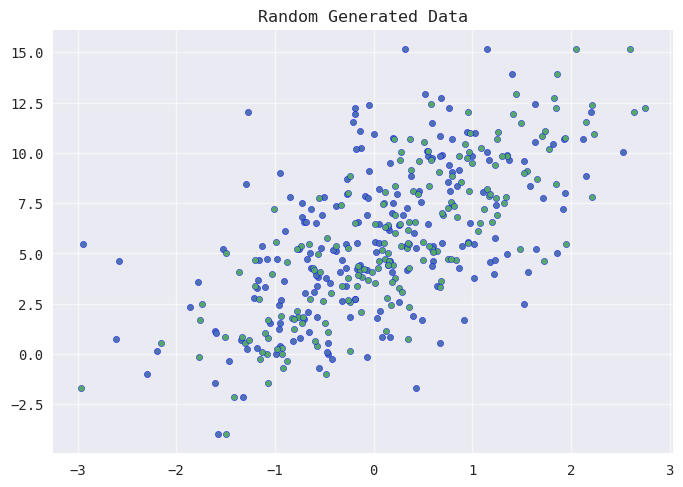

In [4]:
plt.scatter(X[:, 0].numpy(), y.numpy(), s=20, edgecolors="b");
plt.scatter(X[:, 1].numpy(), y.numpy(), s=20, edgecolors="b");
plt.grid(True, alpha = .6);
plt.title("Random Generated Data");
plt.show()

In [5]:
X, X.shape

(tensor([[-4.6601e-01, -1.3021e+00],
         [ 7.5112e-01,  8.8412e-01],
         [ 9.4265e-01,  1.2609e+00],
         [-1.5214e-01, -1.3442e-01],
         [ 1.3700e+00,  2.6741e-01],
         [ 7.7385e-01,  9.6214e-01],
         [ 6.0713e-01, -3.7803e-01],
         [ 1.1698e+00,  5.8206e-01],
         [ 5.4122e-01,  5.4993e-01],
         [ 6.0634e-02, -7.7225e-01],
         [-9.5326e-01, -5.7579e-01],
         [ 6.7348e-01,  1.7106e+00],
         [ 2.1540e+00, -2.3680e-01],
         [ 8.7044e-01,  3.8096e-01],
         [-4.6392e-01, -1.0810e+00],
         [ 1.6320e-01, -1.5081e+00],
         [ 6.7592e-01, -2.1542e+00],
         [-6.6249e-01, -1.2586e-01],
         [ 1.4056e+00,  1.8599e+00],
         [ 1.6393e+00,  5.8361e-01],
         [ 9.1780e-01, -1.7626e+00],
         [-2.2967e+00, -4.8264e-01],
         [-9.0209e-01,  1.0584e+00],
         [ 1.7853e-02,  5.0296e-01],
         [ 2.1207e+00,  2.1018e-01],
         [ 4.7930e-01,  7.8798e-01],
         [ 1.5578e-01,  3.5003e-01],
 

In [6]:
y, y.shape

(tensor([ 5.3290e-01,  8.5620e+00,  1.1047e+01,  4.2257e+00,  9.6285e+00,
          8.1020e+00,  5.3843e+00,  9.6522e+00,  1.0084e+01,  2.1411e+00,
          4.1041e-01,  1.0850e+01,  8.8346e+00,  9.1417e+00,  4.7602e-03,
          8.5586e-01,  5.3404e-01,  2.0830e+00,  1.3915e+01,  1.2425e+01,
          1.7073e+00, -9.7043e-01,  6.1400e+00,  5.5553e+00,  1.0714e+01,
          7.5478e+00,  6.1897e+00,  1.0758e+01,  4.7374e+00,  1.2948e+01,
          3.8353e+00,  1.5643e+00,  8.6803e+00,  7.9946e+00,  7.2066e+00,
          7.8670e+00,  6.4536e+00,  6.5858e+00,  5.3751e+00,  1.0977e+01,
          1.5518e+00,  5.2184e+00,  9.0835e+00,  6.9181e+00,  1.7045e+00,
          1.2258e+01,  7.4934e+00,  9.9015e+00, -1.4575e+00,  4.6735e+00,
          7.9350e-01,  1.2736e+01,  9.8631e+00,  1.0921e+01, -3.9773e+00,
          4.1825e+00,  4.7045e+00,  2.5756e+00,  5.1015e+00, -1.7076e+00,
          6.9197e+00,  2.4231e+00,  1.2236e+01,  8.0878e+00,  6.4368e+00,
          6.6326e-01,  4.2562e+00,  6.

In [7]:
Data = TensorDataset(X, y)
Data.tensors

(tensor([[-4.6601e-01, -1.3021e+00],
         [ 7.5112e-01,  8.8412e-01],
         [ 9.4265e-01,  1.2609e+00],
         [-1.5214e-01, -1.3442e-01],
         [ 1.3700e+00,  2.6741e-01],
         [ 7.7385e-01,  9.6214e-01],
         [ 6.0713e-01, -3.7803e-01],
         [ 1.1698e+00,  5.8206e-01],
         [ 5.4122e-01,  5.4993e-01],
         [ 6.0634e-02, -7.7225e-01],
         [-9.5326e-01, -5.7579e-01],
         [ 6.7348e-01,  1.7106e+00],
         [ 2.1540e+00, -2.3680e-01],
         [ 8.7044e-01,  3.8096e-01],
         [-4.6392e-01, -1.0810e+00],
         [ 1.6320e-01, -1.5081e+00],
         [ 6.7592e-01, -2.1542e+00],
         [-6.6249e-01, -1.2586e-01],
         [ 1.4056e+00,  1.8599e+00],
         [ 1.6393e+00,  5.8361e-01],
         [ 9.1780e-01, -1.7626e+00],
         [-2.2967e+00, -4.8264e-01],
         [-9.0209e-01,  1.0584e+00],
         [ 1.7853e-02,  5.0296e-01],
         [ 2.1207e+00,  2.1018e-01],
         [ 4.7930e-01,  7.8798e-01],
         [ 1.5578e-01,  3.5003e-01],
 

In [8]:
Model = LinearRegression(in_dims=2).to(DEVICE)

In [9]:
trainData, valData = random_split(Data, (0.8, 0.2), generator=GENERATOR)

trainLoader = DataLoader(trainData, batch_size=BATCH_SIZE, shuffle=True)
valLoader = DataLoader(valData, batch_size=BATCH_SIZE, shuffle=True)

In [10]:
trainer = Trainer(
    Model,
    trainLoader,
    valLoader,
    optimizer=optim.SGD(Model.parameters(), lr=.1),
    criterion=nn.L1Loss(reduction='mean'),
    device=DEVICE
)

In [11]:
train_loss, val_loss = trainer.train(num_epochs=NUM_EPOCHS)

	Epoch 1 | Weights: tensor([ 0.8562, -0.1685], device='cuda:0')
	Epoch 1 | Bias: tensor([0.3955], device='cuda:0')
	Epoch 1 | Weights: tensor([ 0.8775, -0.1273], device='cuda:0')
	Epoch 1 | Bias: tensor([0.4830], device='cuda:0')
	Epoch 1 | Weights: tensor([ 0.8990, -0.0840], device='cuda:0')
	Epoch 1 | Bias: tensor([0.5768], device='cuda:0')
	Epoch 1 | Weights: tensor([ 0.8863, -0.0589], device='cuda:0')
	Epoch 1 | Bias: tensor([0.6643], device='cuda:0')
	Epoch 1 | Weights: tensor([ 0.8997, -0.0224], device='cuda:0')
	Epoch 1 | Bias: tensor([0.7643], device='cuda:0')
Epoch 1/50 | Loss: 5.4559
	| Validation Loss: 4.3812

	Epoch 2 | Weights: tensor([0.9067, 0.0166], device='cuda:0')
	Epoch 2 | Bias: tensor([0.8580], device='cuda:0')
	Epoch 2 | Weights: tensor([0.9457, 0.0513], device='cuda:0')
	Epoch 2 | Bias: tensor([0.9393], device='cuda:0')
	Epoch 2 | Weights: tensor([0.9682, 0.0978], device='cuda:0')
	Epoch 2 | Bias: tensor([1.0268], device='cuda:0')
	Epoch 2 | Weights: tensor([0.96

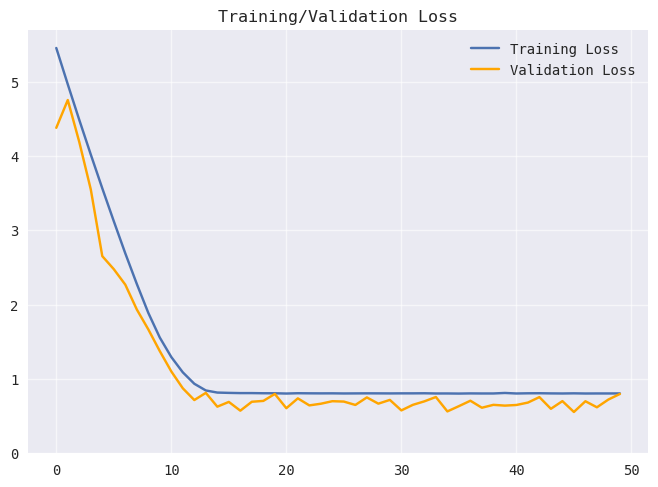

In [18]:
plt.plot(
    train_loss.keys(),
    train_loss.values(),
    label="Training Loss"
);
plt.plot(
    val_loss.keys(),
    val_loss.values(),
    color="orange",
    label="Validation Loss"
);
plt.ylim(bottom=0)
plt.grid(True, alpha = .6);
plt.title("Training/Validation Loss");
plt.legend(loc='best');
plt.show()

In [13]:
# y = 2 * X[:, 0] + 3 * X[:, 1] + 5 + torch.randn(SIZE, dtype=DTYPE, device='cpu')
print(
    f"Trained Weights: {Model.w.data}",
    f"Trained Bias: {Model.b.data}",
    sep="\n"
)

Trained Weights: tensor([2.0410, 2.9498], device='cuda:0')
Trained Bias: tensor([4.9830], device='cuda:0')


In [14]:
T = np.linspace(X.min(), X.max(), SIZE, dtype=np.float32).reshape(SIZE, 1)
T = torch.tensor(np.concatenate([T, T], axis=1), device=DEVICE)

# Inference
with torch.no_grad():
    yT = Model(T)

print(f"\nGenerated T:\n{T}")
print(f"\nPredictions:\n{yT}")


Generated T:
tensor([[-2.9609, -2.9609],
        [-2.9322, -2.9322],
        [-2.9035, -2.9035],
        [-2.8748, -2.8748],
        [-2.8461, -2.8461],
        [-2.8174, -2.8174],
        [-2.7887, -2.7887],
        [-2.7600, -2.7600],
        [-2.7313, -2.7313],
        [-2.7026, -2.7026],
        [-2.6739, -2.6739],
        [-2.6452, -2.6452],
        [-2.6165, -2.6165],
        [-2.5878, -2.5878],
        [-2.5591, -2.5591],
        [-2.5303, -2.5303],
        [-2.5016, -2.5016],
        [-2.4729, -2.4729],
        [-2.4442, -2.4442],
        [-2.4155, -2.4155],
        [-2.3868, -2.3868],
        [-2.3581, -2.3581],
        [-2.3294, -2.3294],
        [-2.3007, -2.3007],
        [-2.2720, -2.2720],
        [-2.2433, -2.2433],
        [-2.2146, -2.2146],
        [-2.1859, -2.1859],
        [-2.1572, -2.1572],
        [-2.1285, -2.1285],
        [-2.0998, -2.0998],
        [-2.0711, -2.0711],
        [-2.0424, -2.0424],
        [-2.0137, -2.0137],
        [-1.9850, -1.9850],
      

In [15]:
T.shape, yT.shape

(torch.Size([200, 2]), torch.Size([200]))

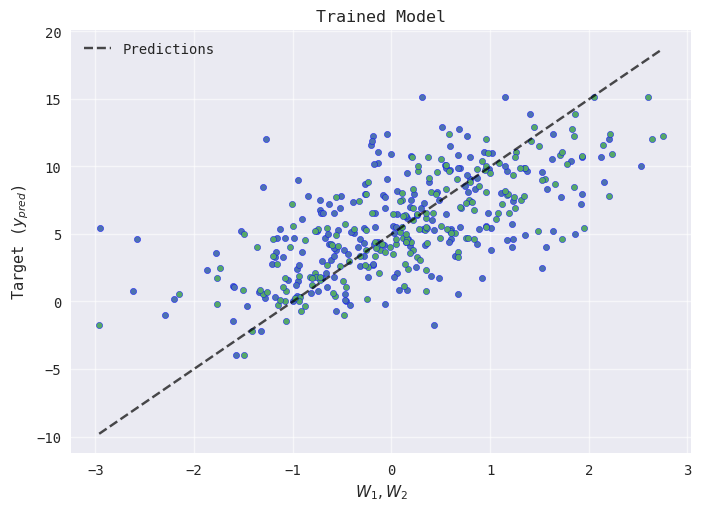

In [16]:
plt.scatter(X[:, 0].numpy(), y.numpy(), s=20, edgecolors="b");
plt.scatter(X[:, 1].numpy(), y.numpy(), s=20, edgecolors="b");
# Predicted Linear Model
plt.plot(T[:, 0].cpu().numpy(), yT.cpu().numpy(), color="black", alpha=.7, linestyle='--', label="Predictions");
plt.grid(True, alpha = .6);
plt.title("Trained Model");
plt.xlabel("$W_1, W_2$");
plt.ylabel("Target ($y_{pred}$)")
plt.legend(loc='best');
plt.show()